# Analyze the gamma rule

## Empirical analysis of LRP-$\gamma$'s forward surrogate model

We now analyse the Eigenvalues of the LRP-$\gamma$'s forward surrogate model for the following cases:

- a 784x784 matrix that represents a learned convolution operation: It performs the global transition from a (flattened) MNIST picture, to a first layer hidden representation of a convolutional network (before nonlinearities)
    - with an MNIST picture, flattened to a 784-dimensional vector
    - with random 784-dimensional input

#### Loading stuff

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from util.util_cnn import get_test_loader, CNN, test
device = "cpu"
PATH = './models/mnist_cnn.torch'

from util.util_gamma_rule import forw_surrogate_matrix, calc_evals_batch, plot_evals_lineplot, global_conv_matrix
from util.util_data_summary import percentile, nth_largest

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.sparse import coo_array

/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparing a real, learned transition matrix (MNIST)

#### Loading stuff

In [2]:
model = CNN().to(device)
model.load_state_dict(torch.load(PATH))

test(model, device, get_test_loader())

/Users/johannes/Repositories/Masterarbeit/util/util_cnn.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.0988, Accuracy: 9708/10000 (97%)



0 torch.Size([1024, 1, 28, 28]) torch.Size([1024])
tensor([[5.9099e-07, 9.9405e-10, 4.0055e-09, 2.1502e-10, 9.9468e-01, 5.1687e-07,
         1.3248e-04, 5.3689e-08, 1.7238e-08, 5.1891e-03]],
       grad_fn=<ExpBackward0>)


/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


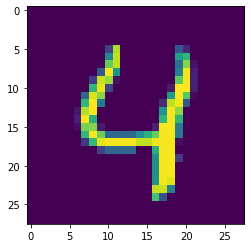

In [3]:
test_loader = get_test_loader(False)

for i, (data, target) in enumerate(test_loader):
    print(i, data.shape, target.shape)
    
    x = data[4]
    plt.imshow(x[0])
    print(model(x).exp())
    
    break

#### Lets express a single (learned) convolutional filter in the form of a global transition matrix

- input dimension is 28x28 = 784
- output dimension is 24x24 = 576
- transition matrix shape is (576, 784)
- (no padding is used)

input: (28, 28)


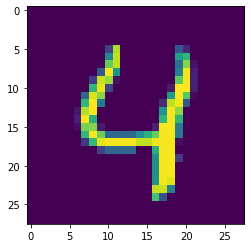

output: (24, 24)


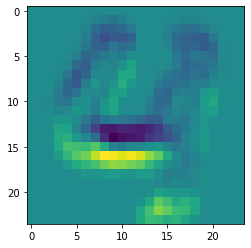

In [4]:
inp = x[0].detach().numpy()

print(f'input: {inp.shape}')
plt.imshow(inp)
plt.show()

out_org = model.conv1(x)[0].detach().numpy()
print(f'output: {out_org.shape}')
plt.imshow(out_org);

In [5]:
conv = model.conv1.weight.detach()[0,0]
bias = model.conv1.bias.detach().numpy()[0]
                            
trans = global_conv_matrix(conv, bias,
                            img_shape=inp.shape,
                            zero_padding=(0,0),
                            sparse_matrix=True)

trans.shape

torch.Size([576, 784])

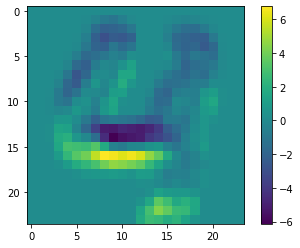

In [6]:
# check that the transition matrix gives the same result as the convolution operation;
out = trans.to_dense() @ inp.flatten()
out = out.reshape((24,24))
plt.colorbar(plt.imshow(out))
assert(np.allclose(out + bias, out_org, atol=0.00001))

In [15]:
# lets make the global transition matrix quadratic by adding some rows of zero
# (this will not change eigenvalues, only add some that are always zero)

trans_prime = np.vstack((trans.to_dense(), np.zeros((trans.shape[1]-trans.shape[0], trans.shape[1]))))
trans_prime.shape

(784, 784)

### [Learned Convolution Matrix, Random Matrix] - Random points

#### Findings

- learned weights only have 24 non-zero Eigenvalues.
- EV of random matrix change much more erratic than those of the learned weights.

trans_prime has by construction only 25 non-null entries per row. The structure is a sort of block-diagonal.
(array([ 0, 25]), array([208, 576]))


Text(0.5, 1.0, 'trans_prime values')

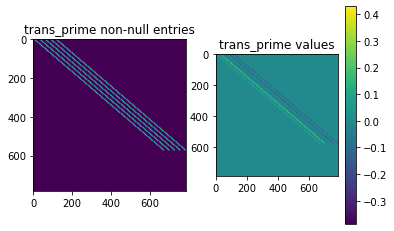

In [16]:
print("trans_prime has by construction only 25 non-null entries per row. The structure is a sort of block-diagonal.")
print(np.unique((trans_prime != 0).sum(axis=1), return_counts=True))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(trans_prime != 0)
plt.colorbar(ax2.imshow(trans_prime))

ax1.set_title("trans_prime non-null entries")
ax2.set_title("trans_prime values")

#### EV plot

In [50]:
global_seed = 100

# define experiment
n_points = 1
n_gammas = 501
gammas = np.linspace(0, 20, n_gammas)

# mean & standard deviation
points_params = (0, 1)

# generate random datapoints
np.random.seed(1 + global_seed)
points_list = np.random.normal(*points_params, size = (n_points, trans_prime.shape[1]))

In [51]:
big_random_matrix = np.random.normal(*weights_params, size=trans_prime.shape) # random matrix of same shape as trans_prime
big_random_matrix_w_zeros = big_random_matrix                       
big_random_matrix_w_zeros[trans.shape[1]-trans.shape[0]:] = 0                 # matrix where last rows are zero (like trans_prime)

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:114: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / res_unnormalized


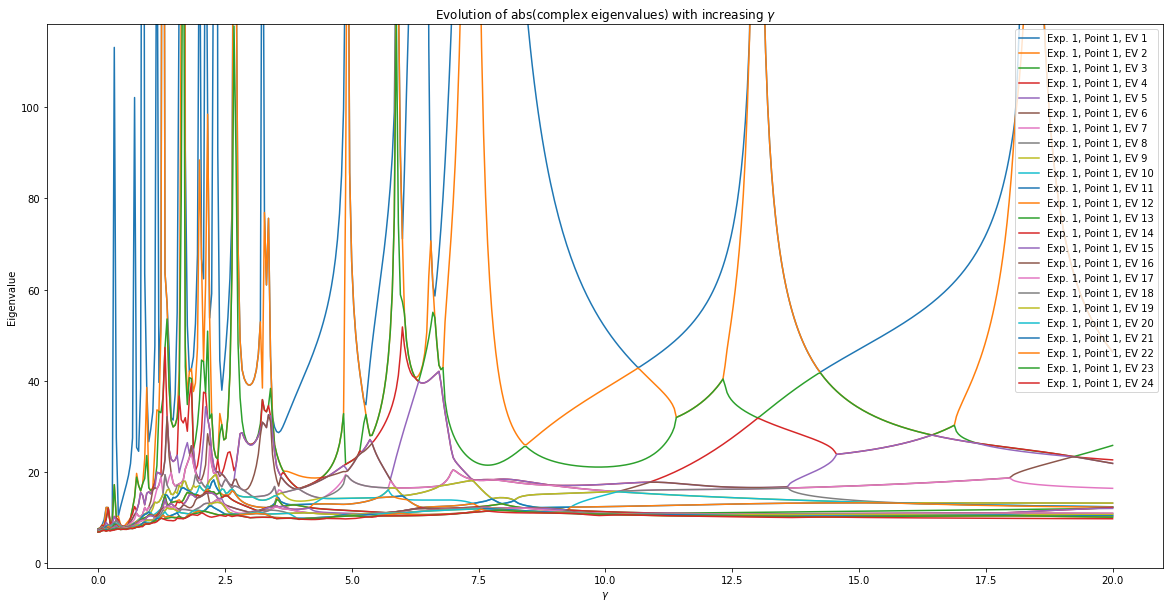

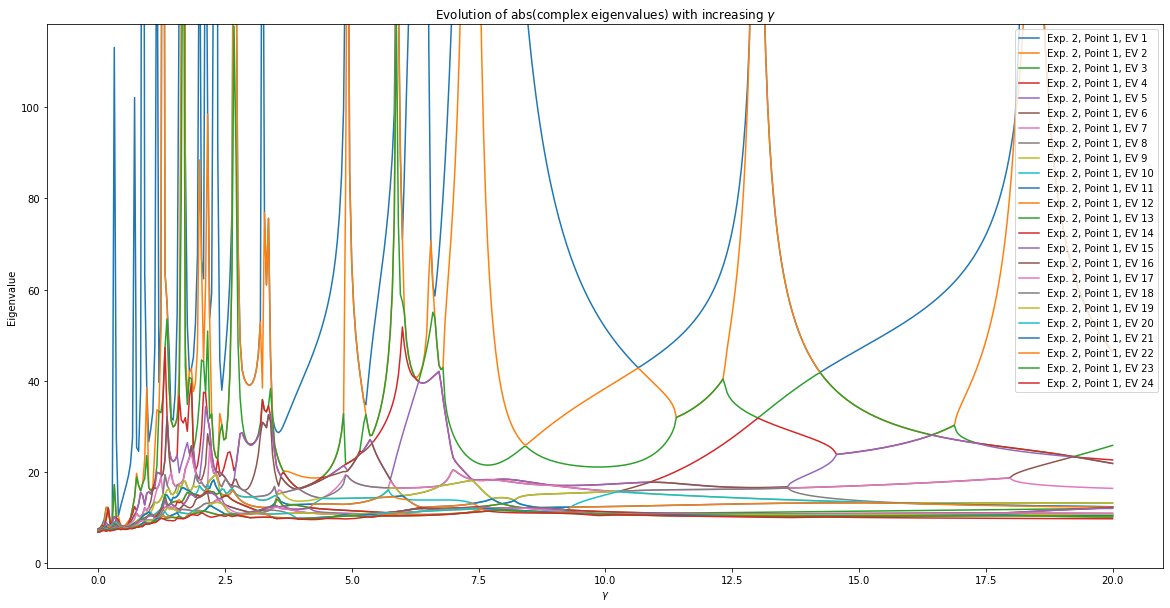

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:114: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / res_unnormalized


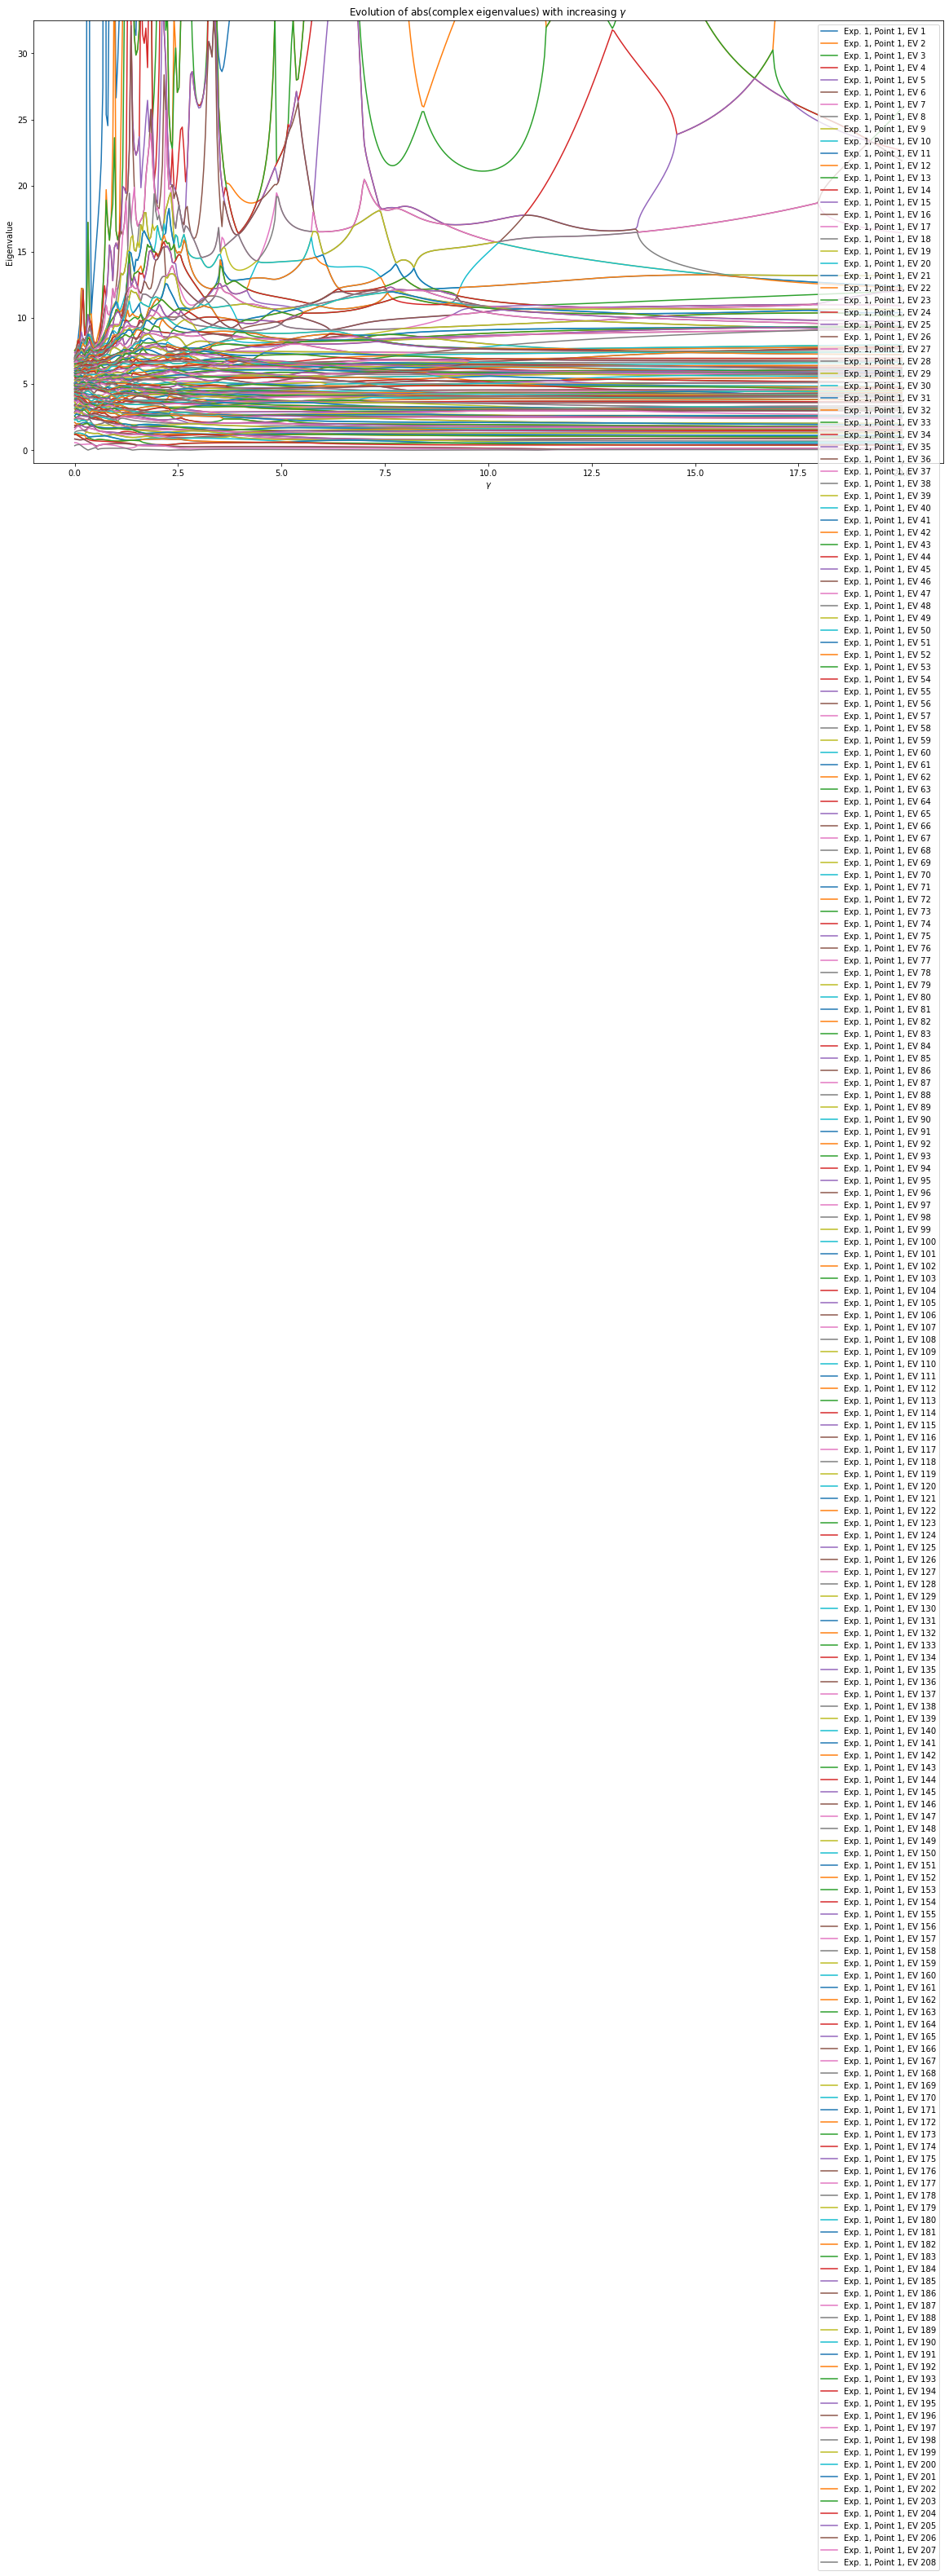

In [52]:
# at first we plot the top 24 EVs of the real transition matrix and of the random 784*784 matrix.
computed_evals = calc_evals_batch([trans_prime, big_random_matrix_w_zeros], points_list, gammas, num_evals=24)
plot_evals_lineplot(computed_evals, gammas, mark_positive_slope=False, percentile_to_plot=99)

# then we plot all 784 EVs of the random matrix.
computed_evals = calc_evals_batch([big_random_matrix_w_zeros], points_list, gammas)
plot_evals_lineplot(computed_evals, gammas, mark_positive_slope=False, percentile_to_plot=99)

#### Highlight one EV discontinuity

-> For some values of Gamma an Eigenvalue diverges.

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:114: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / res_unnormalized


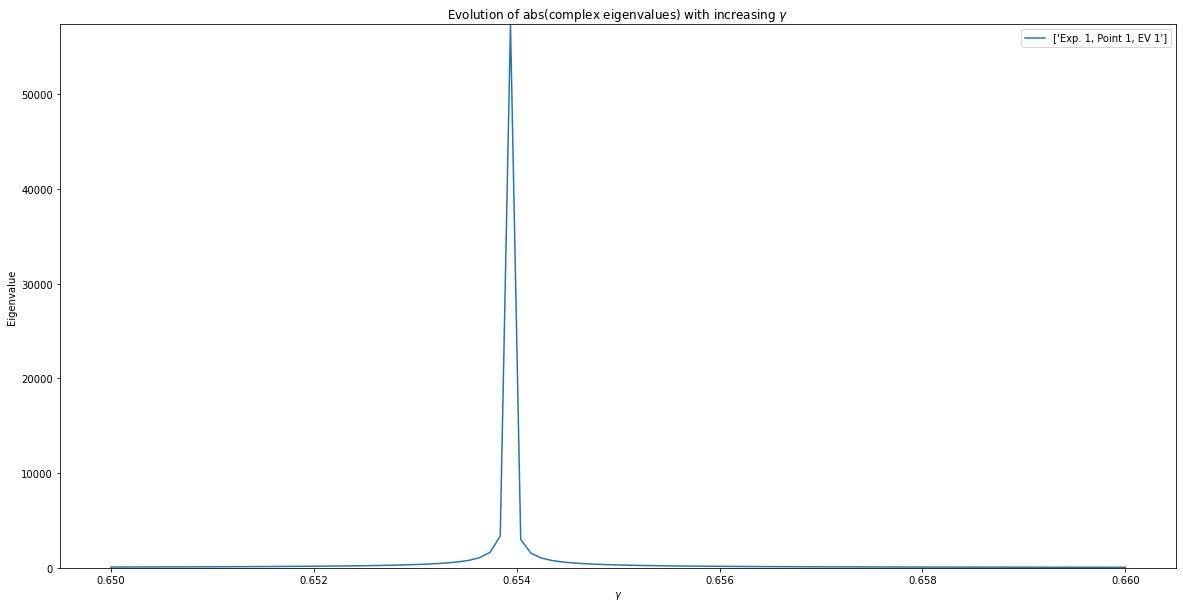

In [48]:
gammas=np.linspace(.65, .66, 100)

np.random.seed(5)
points_list = np.random.normal(0, 1, size = (1, trans_prime.shape[1]))

computed_evals = calc_evals_batch([trans_prime], 
            points_list=points_list, 
            gammas=gammas,
            num_evals=1)

plot_evals_lineplot(computed_evals, gammas, mark_positive_slope=False, percentile_to_plot=100)

### [Learned Convolution Matrix, Random Matrix] - Real data points / MNIST pictures

#### Findings

- with real (learned not random) transitions **and** real datapoints, the EV develop very smoothly
- the general trend is that **with higher gamma, fewer EV have a high activation**.

In [54]:
n_points = 3

real_points_list = data.flatten(1,3).detach().numpy()
print(real_points_list.shape)
print(real_points_list[:n_points].shape)

(1024, 784)
(3, 784)


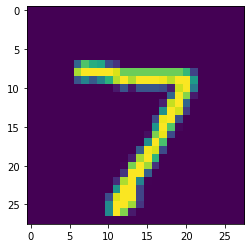

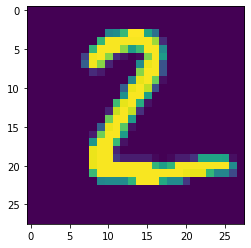

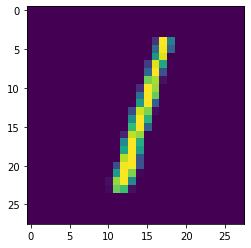

In [55]:
for i in range(n_points):
    plt.imshow(data[i].detach().numpy()[0])
    plt.show()

#### Gamma in [0, 20]

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:114: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / res_unnormalized


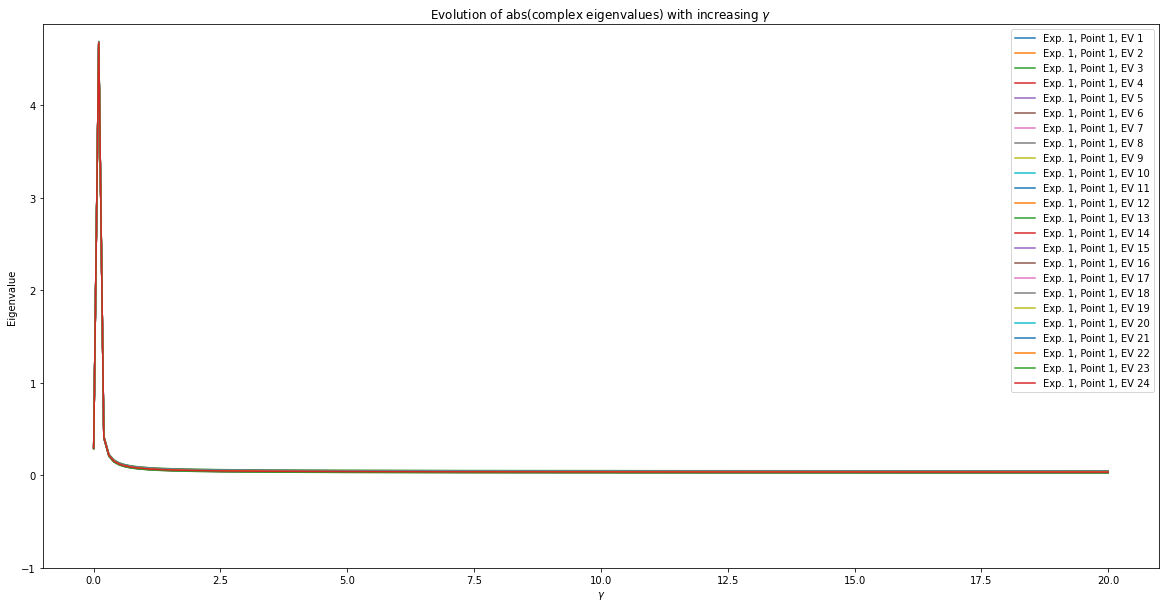

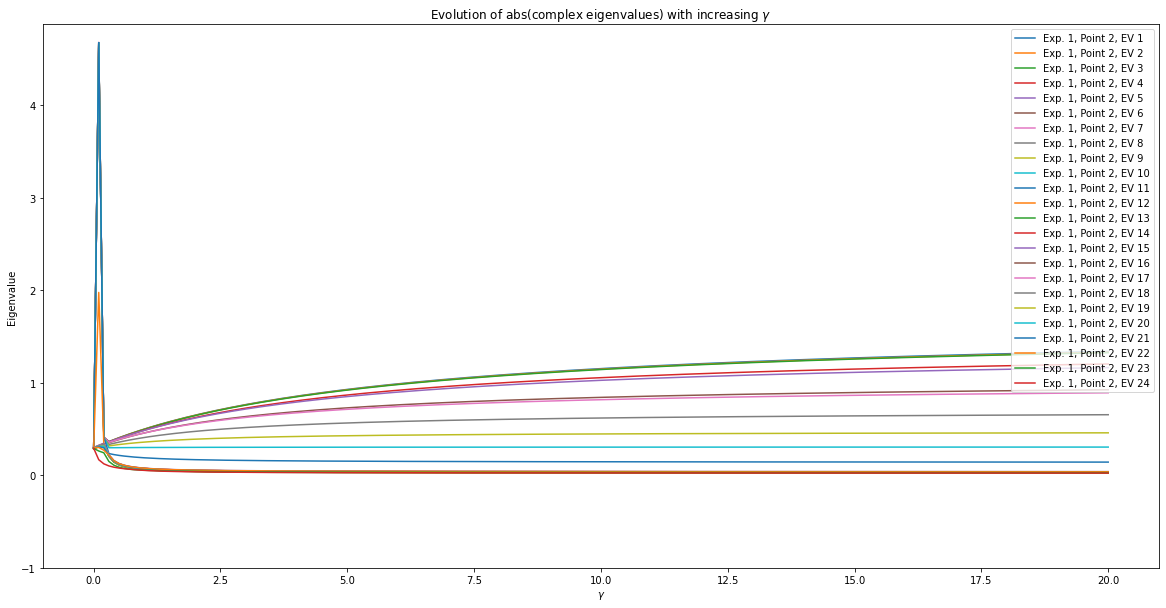

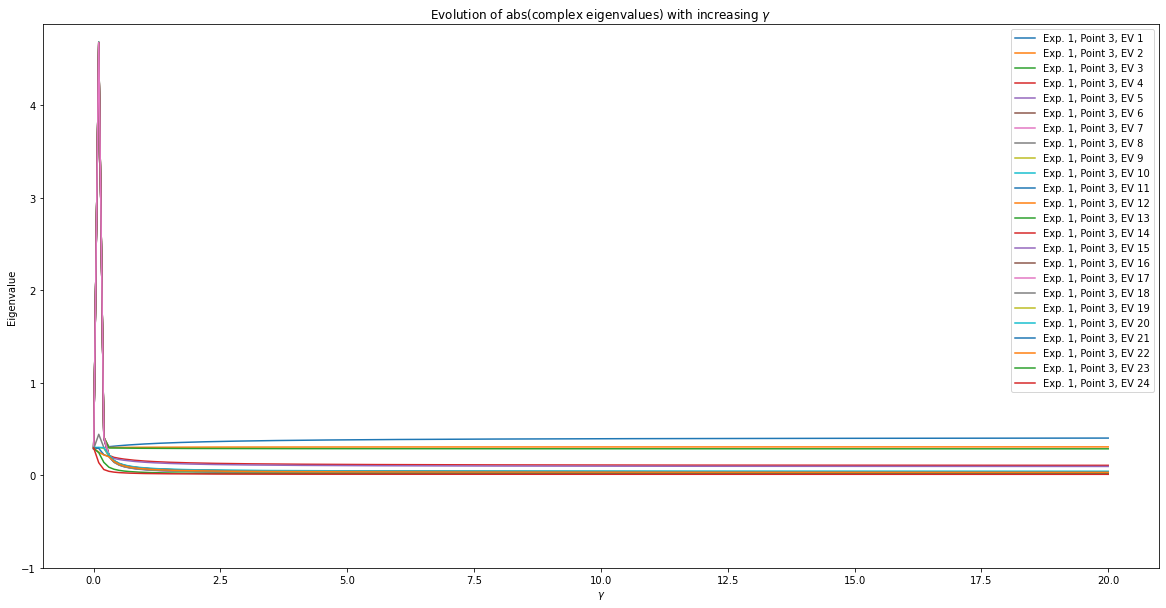

In [57]:
gammas=np.linspace(0, 20, 201)

computed_evals = calc_evals_batch([trans_prime], real_points_list[:n_points], gammas, num_evals=24)
plot_evals_lineplot(computed_evals, gammas, mark_positive_slope=False, percentile_to_plot=99.99, one_plot_per='point')


#### Gamma in [0, 5]

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:114: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / res_unnormalized


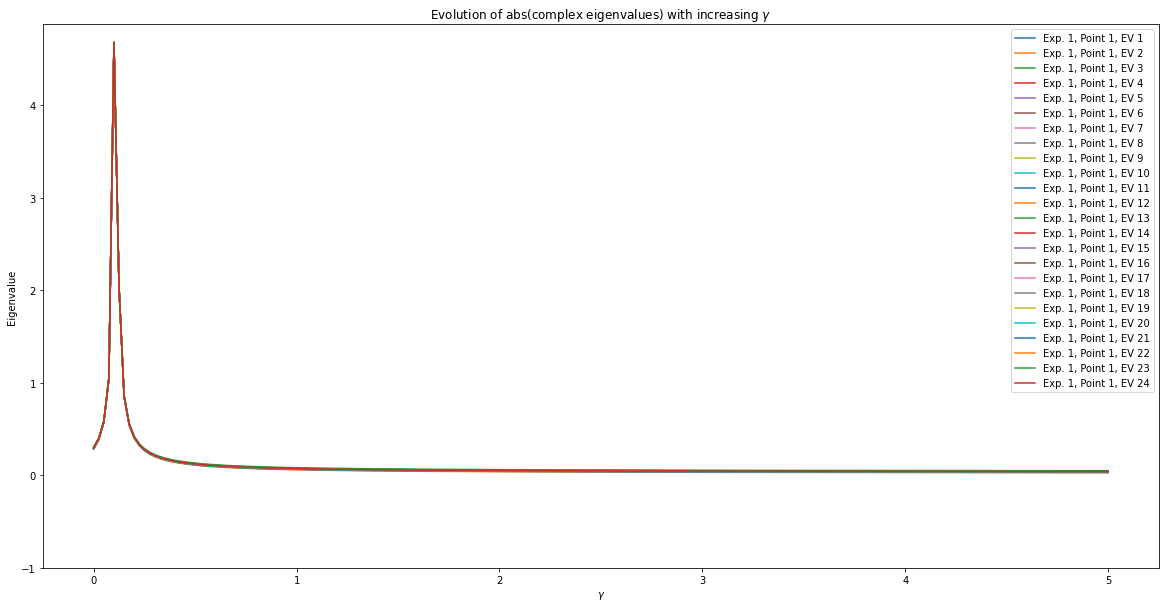

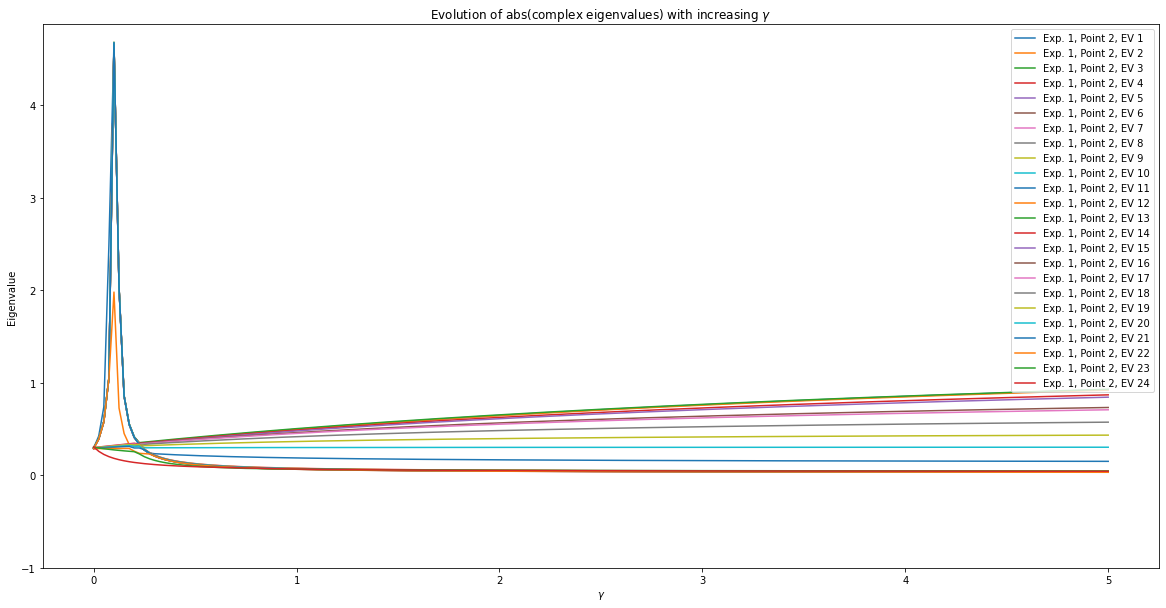

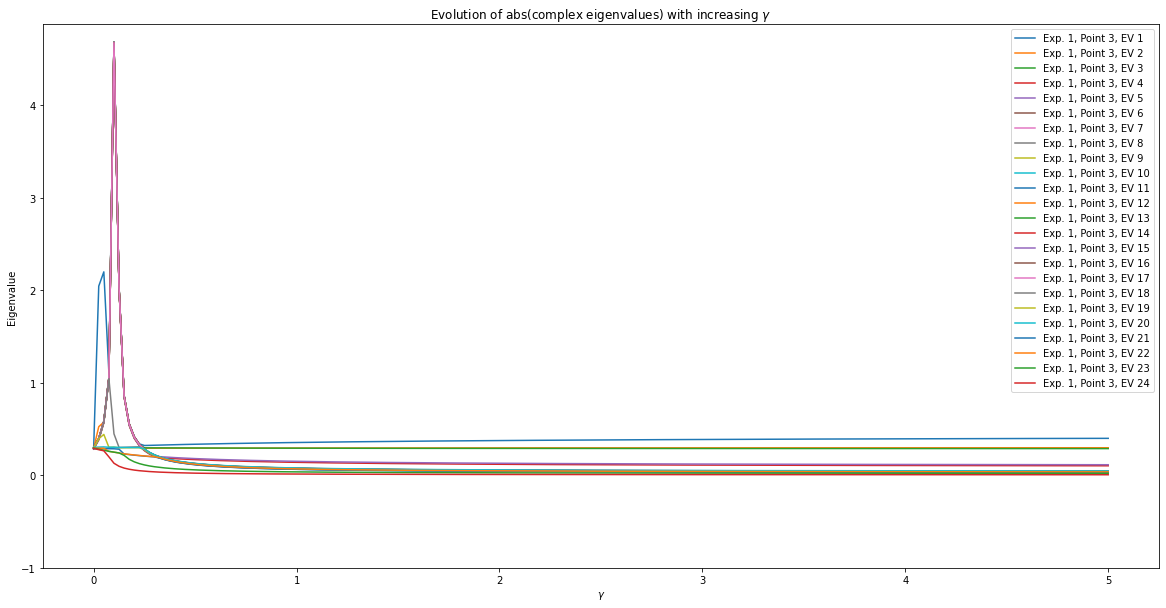

In [58]:
gammas=np.linspace(0, 5, 201)

computed_evals = calc_evals_batch([trans_prime], real_points_list[:n_points], gammas, num_evals=24)
plot_evals_lineplot(computed_evals, gammas, mark_positive_slope=False, percentile_to_plot=99.99, one_plot_per='point')


#### Gamma in [0, 0.3]

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:114: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / res_unnormalized


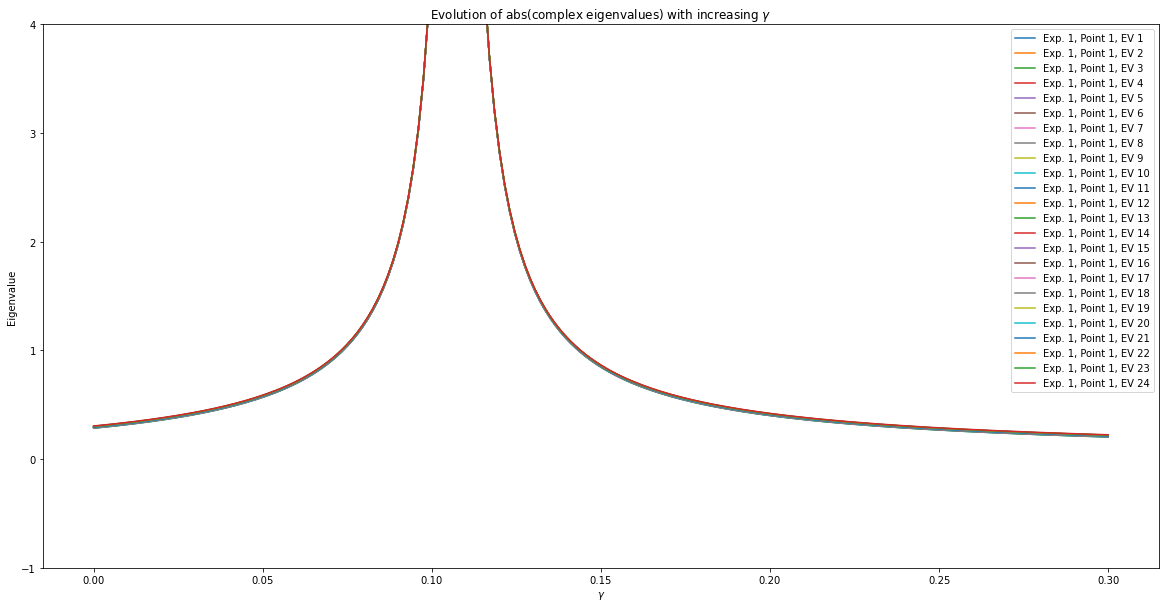

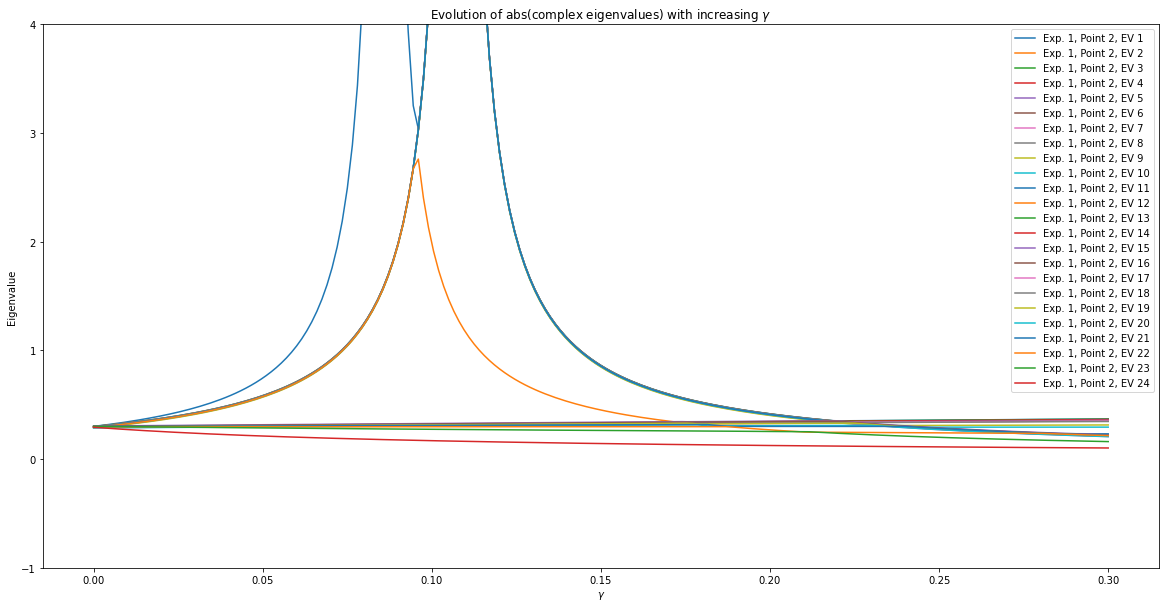

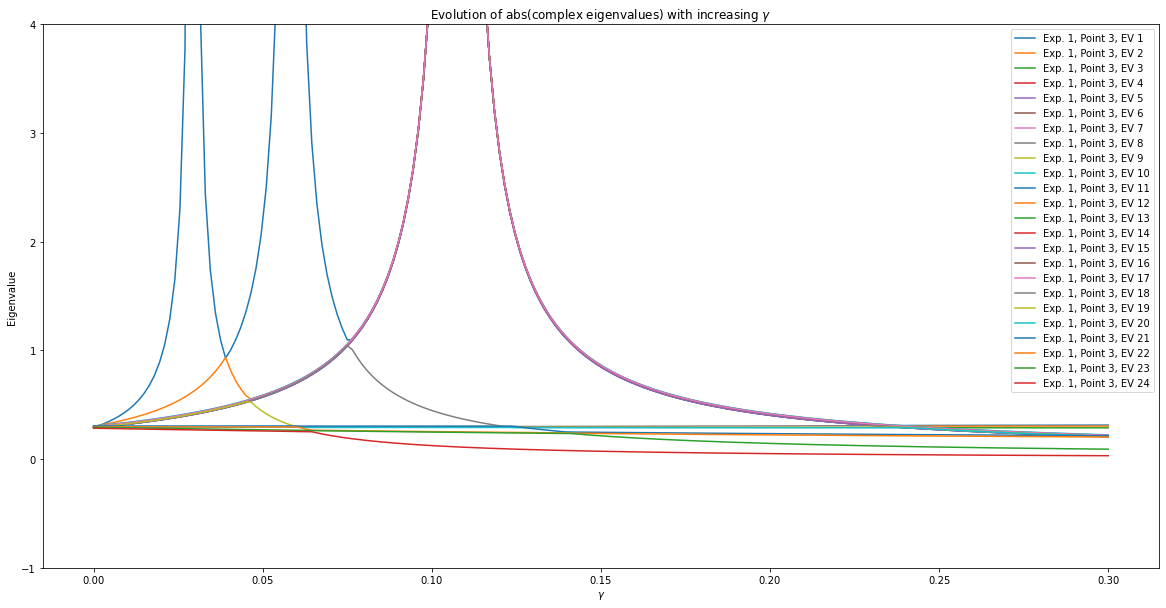

In [59]:
# zoom in
gammas=np.linspace(0, 0.3, 201)

computed_evals = calc_evals_batch([trans_prime], real_points_list[:n_points], gammas, num_evals=24)
plot_evals_lineplot(computed_evals, gammas, mark_positive_slope=False, one_plot_per='point')

## Without normalization
- Result: boring, because all EVs grow linaearly, and also the differences between them.

In [9]:
conv = model.conv1.weight.detach()[0,0]
bias = model.conv1.bias.detach().numpy()[0]
                            
trans = global_conv_matrix(conv, bias,
                            img_shape=inp.shape,
                            zero_padding=(0,0),
                            sparse_matrix=True)

trans.shape

torch.Size([576, 784])

In [33]:
# lets make the global transition matrix quadratic by adding some rows of zero
# (this will not change eigenvalues, only add some that are always zero)

trans_prime = torch.sparse_coo_tensor(indices = trans.coalesce().indices(),
                                        values = trans.coalesce().values(),
                                        size=(trans.shape[1], trans.shape[1]))
trans_prime.shape

torch.Size([784, 784])

In [53]:
gammas = [0, .25]
gammas = np.linspace(0,10, 21)
print(gammas)

computed_evals = calc_evals_batch([trans_prime], None, gammas, num_evals=900, normalization=False)

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
Warn: too high number of evals requested (900). We instead return 784.
784


In [55]:
(computed_evals != 0).sum(axis=3)

array([[[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
         24, 24, 24, 24, 24]]])

24
(1, 1, 21, 784)


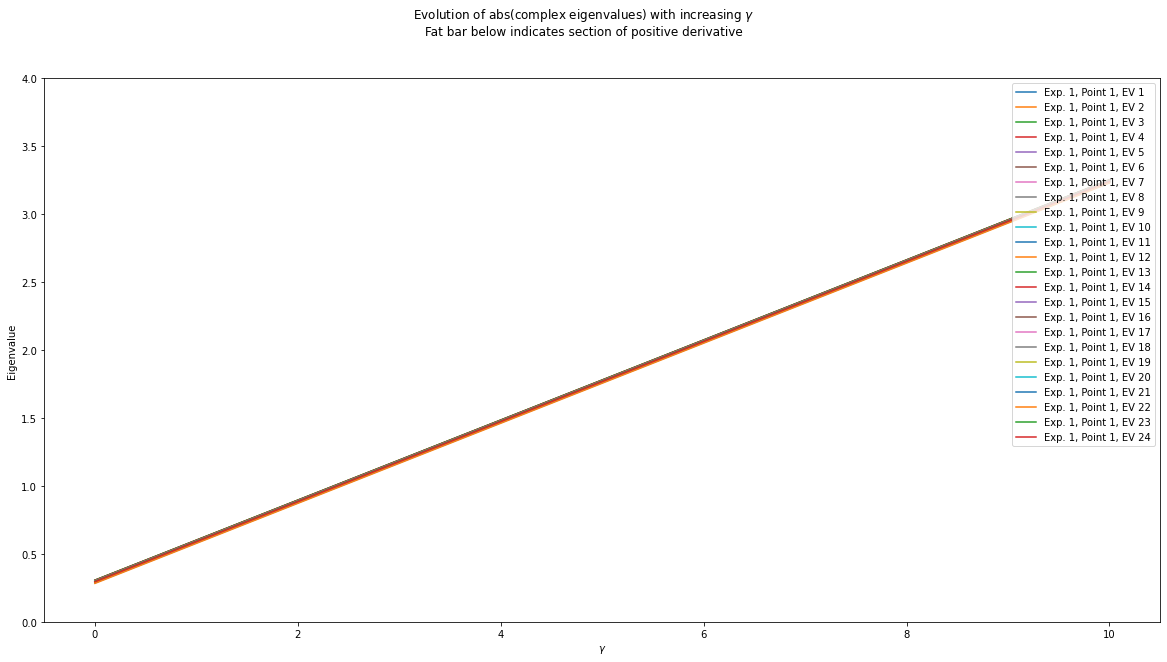

In [61]:
plot_evals_lineplot(computed_evals, gammas, 24)

In [69]:
computed_evals[0,0].std(axis=1), computed_evals[0,0].max(axis=1) - computed_evals[0,0].min(axis=1)

(array([0.05074834, 0.07612251, 0.10149667, 0.12687084, 0.15224501,
        0.17761917, 0.20299335, 0.22836753, 0.25374168, 0.27911586,
        0.30449   , 0.32986419, 0.35523837, 0.38061251, 0.4059867 ,
        0.43136084, 0.45673503, 0.48210921, 0.50748335, 0.53285754,
        0.55823168]),
 array([0.29459506, 0.44189259, 0.58919013, 0.73648763, 0.88378519,
        1.03108263, 1.17838025, 1.32567787, 1.47297525, 1.62027287,
        1.76757026, 1.91486788, 2.0621655 , 2.20946288, 2.3567605 ,
        2.50405788, 2.6513555 , 2.79865313, 2.94595051, 3.09324813,
        3.24054551]))

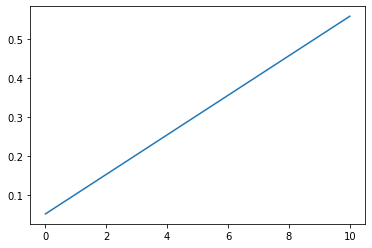

In [67]:
plt.plot(gammas, computed_evals[0,0].std(axis=1))

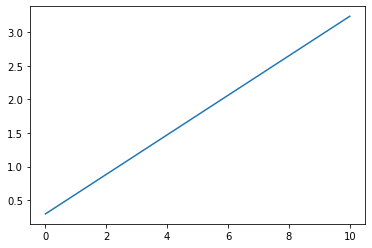

In [70]:
plt.plot(gammas, computed_evals[0,0].max(axis=1) - computed_evals[0,0].min(axis=1))

## Backward matrices



### Scipy sparse capabilities

In [7]:
arr = np.diag(np.arange(4))
arr[0,0] = -1

arr = coo_array(arr)
print(arr)

  (0, 0)	-1
  (1, 1)	1
  (2, 2)	2
  (3, 3)	3


In [10]:
arr = arr * (arr > 0)
print(arr)

  (1, 1)	1
  (2, 2)	2
  (3, 3)	3


In [5]:
print(arr * np.arange(4)[None, :])

  (0, 1)	6
  (1, 1)	1
  (2, 2)	4
  (3, 3)	9


In [6]:
arr[2, 0] = 7

TypeError: 'coo_array' object does not support item assignment

## Other investigations

### Comparing [**Learned Convolution matrix**, **Random matrix**] one on one, with **real MNIST datapoints**

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 1, Point 1: 24 of 24 Eigenvalues are non-zero. 24 get plotted.


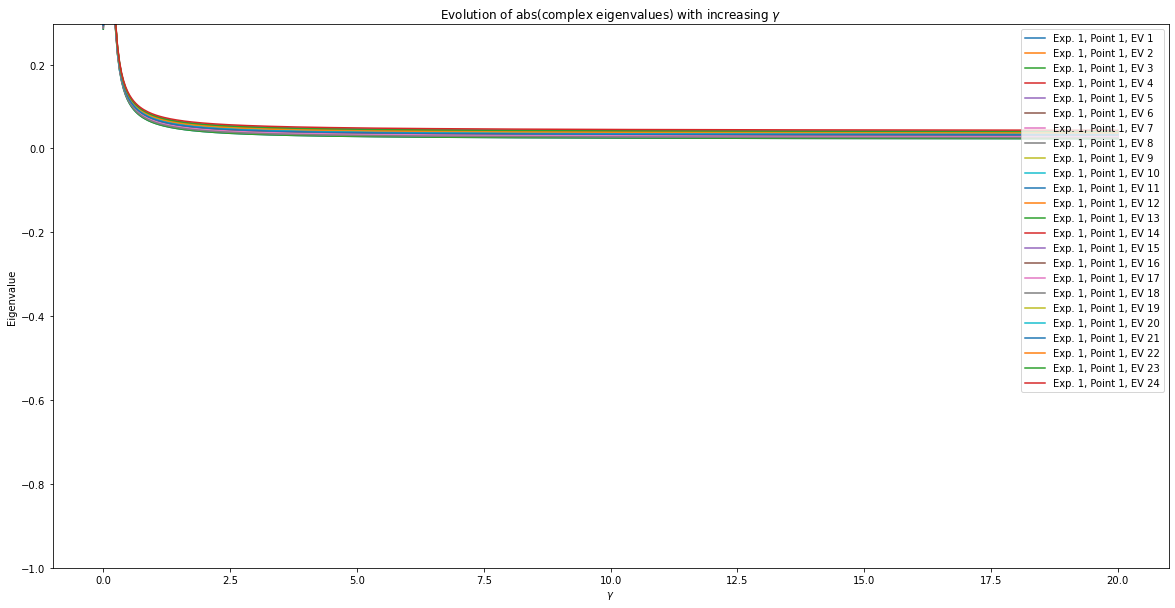

/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


Matrix 2, Point 1: 208 of 208 Eigenvalues are non-zero. 24 get plotted.


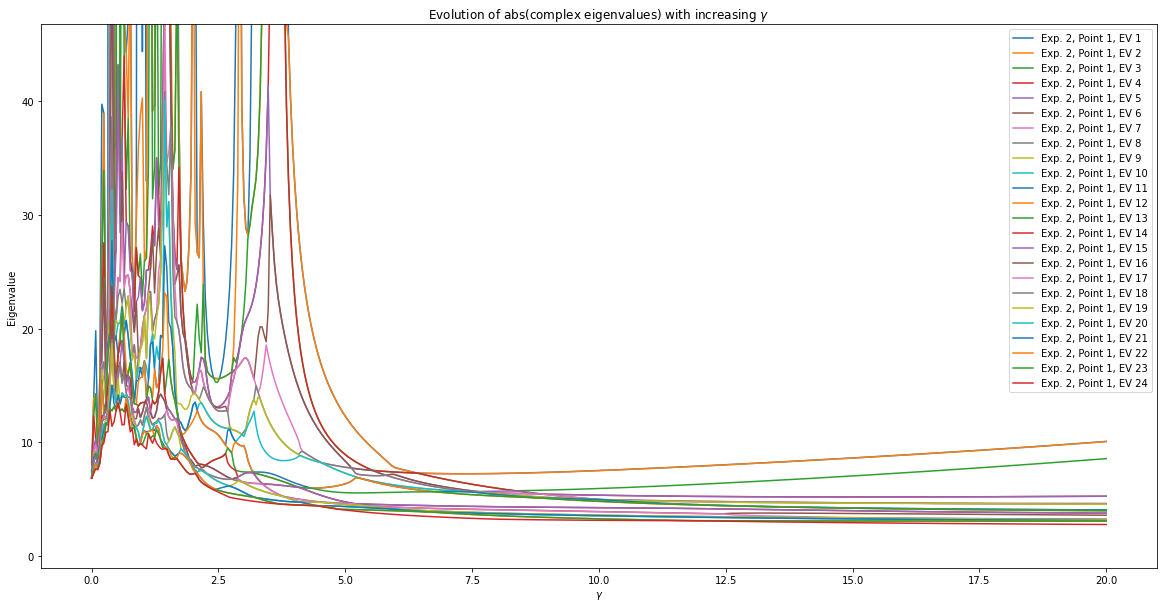

In [49]:
index = 0
gammas=np.linspace(0, 20, 201)

computed_evals = calc_evals_batch([trans_prime, big_random_matrix_w_zeros], real_points_list[index], gammas, num_evals=24)
plot_evals_lineplot(computed_evals, gammas, mark_positive_slope=False, percentile_to_plot=99, one_plot_per='point')

In [65]:
index = 0
gammas=np.linspace(0, 20, 201)

computed_evals = calc_evals_batch([trans_prime, big_random_matrix_w_zeros], real_points_list[index], gammas, num_evals=24)
plot_evals_lineplot(computed_evals, gammas, mark_positive_slope=False, percentile_to_plot=99, one_plot_per='point')

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

### Plot outputs for a few Gammas

--> Nothing to see, as activations are recovered perfectly locally.

0
(784,)
(24, 24)


/Users/johannes/Repositories/Masterarbeit/util/util_gamma_rule.py:17: RuntimeWarning: invalid value encountered in true_divide
  forwards_ratio = foll / (R_i_to_j @ curr)


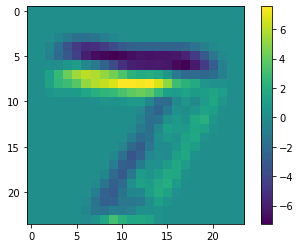

1
(784,)
(24, 24)


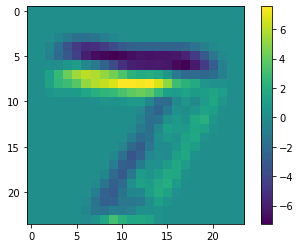

5
(784,)
(24, 24)


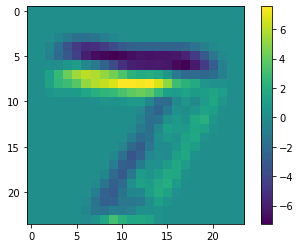

10
(784,)
(24, 24)


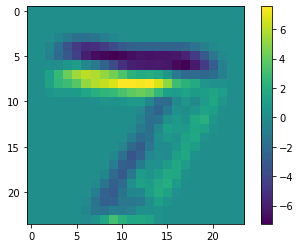

20
(784,)
(24, 24)


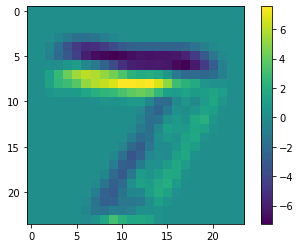

100
(784,)
(24, 24)


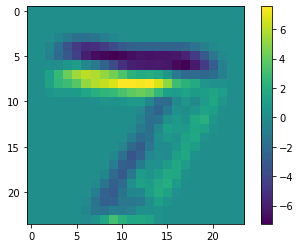

1000
(784,)
(24, 24)


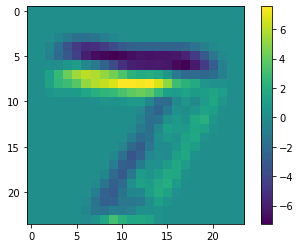

In [51]:
index = 0
x
for gamma in [0, 1, 5, 10, 20, 100, 1000]:
    print(gamma)
    curr = real_points_list[index]

    mat = forw_surrogate_matrix(trans_prime, curr, gamma)

    out = mat @ curr
    print(out.shape)
    out = out[:576].reshape((24,24))
    print(out.shape)
    plt.colorbar(plt.imshow(out))
    plt.show()
    